In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils.datapreparation import my_division_data, penobscot_data
from matplotlib.lines import Line2D
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Modelo

In [49]:
train_image,train_label, test_image, test_label, val_image, val_label=my_division_data(shape=(992,576), stridetrain=(992,576), strideval=(992,576), stridetest=(992,576))


In [41]:
model = tf.keras.models.load_model('/scratch/nunes/seismic_models/article_model_my_division.keras')
num_classes=6

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 992, 576, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 992, 576, 16)         1952      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 992, 576, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 992, 576, 16)         30992     ['activation[0][0]']          
                                                                                              

In [43]:
LAYER_NAME='conv2d_22'

## Funções

In [44]:
class GradCAMModel(tf.keras.Model):
    def __init__(self, model, conv_layer_name):
        super(GradCAMModel, self).__init__()
        self.segmentation_model = model
        self.extractor = tf.keras.Model(inputs=model.inputs, outputs=[model.get_layer(conv_layer_name).output])

    def call(self, x):
        feature_map = self.extractor(x)
        return feature_map

# Inicialize o modelo GradCAM
#Ativaco central: attunet_up1_conv_after_concat_3_activation
#primeira metade: attunet_down2_conv_3_activation (ruim demais)
#Ultima ativacao: attunet_up4_conv_after_concat_3_activation
#Ultima Camada: attunet_output
gradcam_model = GradCAMModel(model, LAYER_NAME)

# Defina uma função para calcular os gradientes com relação ao mapa de ativação da classe
@tf.function
def compute_gradcam(image, class_idx):
    with tf.GradientTape() as tape:
        feature_map = gradcam_model(image)
        loss = tf.reduce_mean(feature_map[:, :, :, class_idx])

    grads = tape.gradient(loss, feature_map)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, feature_map), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    # Retorna o mapa de calor Grad-CAM como um tensor TensorFlow
    return heatmap


In [45]:
def heatmap_image(heatmap):
    heatmap = heatmap.squeeze()
    heatmap_normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalizando o heatmap entre 0 e 1
    return heatmap_normalized

In [46]:
def visualize_prediction(image, true_mask, predicted_mask):
    true_mask=true_mask.squeeze()
    fig, axes = plt.subplots(1, 3, figsize=(5, 5), sharey=True)

    predicted_mask = np.argmax(predicted_mask[0], axis=-1)
    accuracy = np.mean(true_mask == predicted_mask) * 100
    class_colors = plt.cm.viridis(np.linspace(0, 1, num_classes))[:, :3]
    class_labels = [f'Classe {cls}' for cls in range(len(class_colors))]

    #Ground Truth
    overlay_true_mask = np.zeros(image.squeeze().shape + (3,), dtype=np.float32)
    for cls, color in enumerate(class_colors):
        overlay_true_mask[true_mask == cls] = color
    axes[1].imshow(overlay_true_mask)
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    #Prediction
    overlay_predicted_mask = np.zeros(image.squeeze().shape + (3,), dtype=np.float32)
    for cls, color in enumerate(class_colors):
        overlay_predicted_mask[predicted_mask == cls] = color
    axes[2].imshow(overlay_predicted_mask)
    axes[2].set_title(f"Prediction\nAccuracy: {accuracy:.2f}%")
    axes[2].axis('off')


    #Legend
    legend_axe = axes[0]
    legend_axe.axis('off')
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=10)
                       for color, label in zip(class_colors, class_labels)]
    legend_axe.legend(handles=legend_elements, loc='lower left')

In [47]:
def visualize_gradcam(image, true_mask, predicted_mask):
    true_mask=true_mask.squeeze()
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 5), sharey=True)

    predicted_mask = np.argmax(predicted_mask[0], axis=-1)
    class_colors = plt.cm.viridis(np.linspace(0, 1, 6))[:, :3]
    class_labels = [f'Classe {cls}' for cls in range(len(class_colors))]


    #Activations
    for target_class in range(0,num_classes):
        heatmap=compute_gradcam(image, target_class).numpy()
        heat_img=heatmap_image(heatmap)
        im = axes[target_class].imshow(heat_img)
        axes[target_class].set_title(f"Class {target_class}")
        axes[target_class].axis('off')
    
    fig.colorbar(im, ax=axes, orientation='horizontal', shrink=0.8,format='')

## Visualização

In [50]:
img_pos=100
image=test_image[img_pos:img_pos+1,:,:]
label=test_label[img_pos:img_pos+1,:,:]
predicted_label=model.predict(image)

1/1 [==============================] - 1s 690ms/step


2024-07-15 12:46:50.483953: W tensorflow/core/kernels/conv_ops_gpu.cc:144] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 1
in_depths: 48
out_depths: 16
in: 992
in: 576
data_format: 1
filter: 11
filter: 11
filter: 48
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 5
padding: 5
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_8.9 with 25386352640B RAM, 128 cores, 2565000KHz clock, 10501000KHz mem clock, 75497472B L2$"
fusion {
  activation_mode: kRelu
  conv_scale: 1
}
version: 3



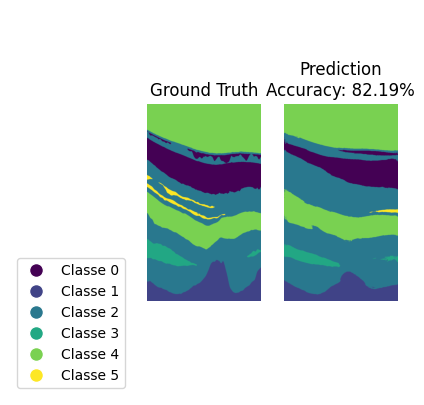

In [51]:
visualize_prediction(image,label,predicted_label)

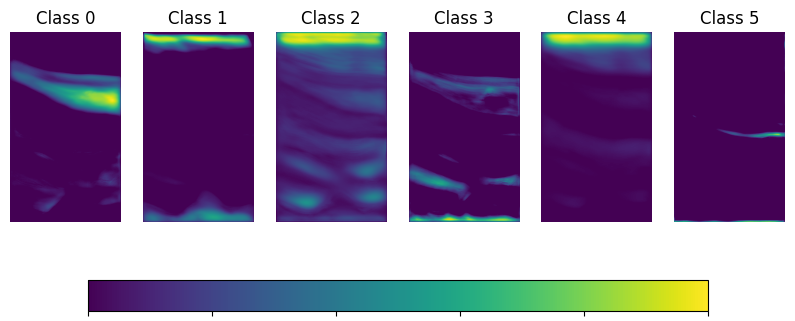

In [52]:
visualize_gradcam(image,label,predicted_label)